In [2]:
from board_labeler import getFiles

filesDir = "labeledConstSize/"

paths = getFiles(filesDir)

In [3]:
import cv2
import re
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

stringLen = len(filesDir)
m = re.compile(r"([a-zA-Z]+(_[a-zA-Z]+)?)_")



X = [cv2.imread(x) for x in paths]
y = [m.findall(x)[0][0] for x in paths]

dictClasses = {
    "empty":0,
    "bishop_black":1,
    "bishop_white":2,
    "king_black":4,
    "king_white":5,
    "knight_black":6,
    "knight_white":7,
    "pawn_black":8,
    "pawn_white":9,
    "queen_black":10,
    "queen_white":11,
    "rook_black":12,
    "rook_white":13,
}
y = [[dictClasses[x]] for x in y]

# temp1 = [x.shape for x in X]
# temp = set(temp1)

# temp3 = [temp1.count(x) for x in temp]
# print(temp)
# print(temp3)

print(f"{len(X)} {len(y)}")



3224 3224


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.asanyarray(X)
y = np.asanyarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.2, 0.8), horizontal_flip=True, vertical_flip=True)
generator = datagen.flow_from_directory("labeledConstSize/", target_size=(150, 150), batch_size=32, class_mode="categorical")

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(500, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(250, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(100, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(14, activation = tf.nn.softmax)])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(X_train,y_train,epochs=20)


Epoch 1/20
68/68 [==============================] - 2s 18ms/step - loss: 395.5876 - accuracy: 0.6403
Epoch 2/20
68/68 [==============================] - 1s 18ms/step - loss: 62.6039 - accuracy: 0.7676
Epoch 3/20
68/68 [==============================] - 1s 18ms/step - loss: 14.7927 - accuracy: 0.8676
Epoch 4/20
68/68 [==============================] - 1s 18ms/step - loss: 5.5663 - accuracy: 0.9245
Epoch 5/20
68/68 [==============================] - 1s 18ms/step - loss: 2.7663 - accuracy: 0.9491
Epoch 6/20
68/68 [==============================] - 1s 18ms/step - loss: 3.6447 - accuracy: 0.9426
Epoch 7/20
68/68 [==============================] - 1s 18ms/step - loss: 3.5170 - accuracy: 0.9366
Epoch 8/20
68/68 [==============================] - 1s 18ms/step - loss: 1.7377 - accuracy: 0.9657
Epoch 9/20
68/68 [==============================] - 1s 17ms/step - loss: 5.0909 - accuracy: 0.9301
Epoch 10/20
68/68 [==============================] - 1s 17ms/step - loss: 1.9710 - accuracy: 0.9597
Epoch

In [6]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.29006338119506836
Test accuracy: 0.9906014800071716


In [7]:
model.save("models/firstmodel")

INFO:tensorflow:Assets written to: models/firstmodel\assets


In [9]:
from board_finder import getBoardCoords,imageResize

img = imageResize(cv2.imread("Board_Examples/medium2.png"), 0.5)

imgs = getBoardCoords(img)

# #print(imgs[0])
# temp1 = [x.shape for x in imgs]
# temp = set(temp1)

# temp3 = [temp1.count(x) for x in temp]
# print(temp)
# print(temp3)

imgs = [x for x in imgs if x.shape == (47,47,3)]


predictionClass = model.predict(np.array(imgs)) # ALWAYS USE NP.ARRAY AND GIVE IT AN ARRAY TO PREDICT

dct = {v: k for k, v in dictClasses.items()} # Inverse dictionary with 0=>empty, 1=>black_bishop, 2=>white_bishop, etc.

classPredicted = dct[predictionClass[0].argmax()] # Get the class with the highest probability

print(classPredicted) # Print the class with the highest probability




rook_black


In [10]:
%matplotlib inline

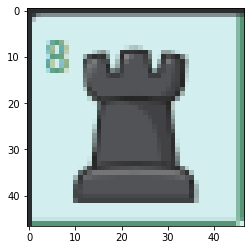

rook_black


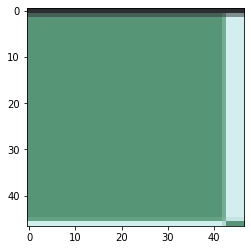

empty


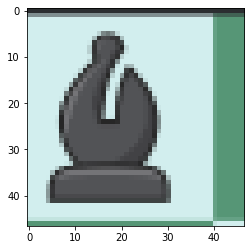

pawn_black


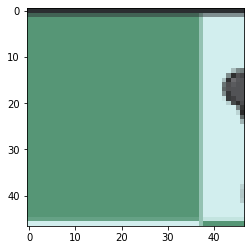

empty


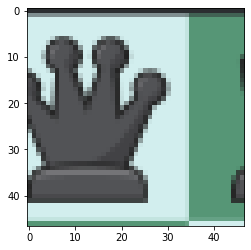

empty


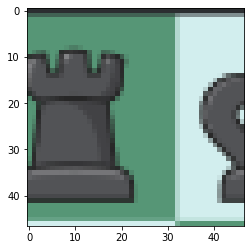

empty


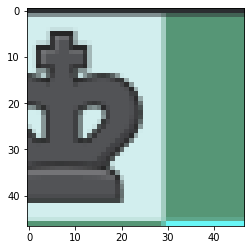

empty


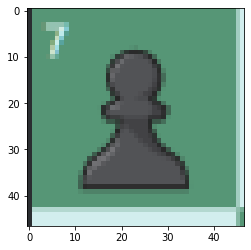

pawn_black


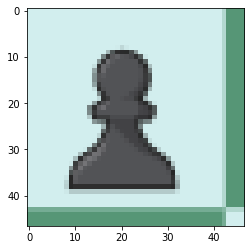

pawn_black


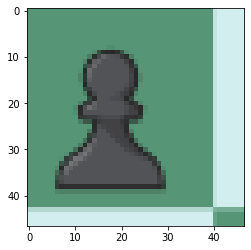

queen_black


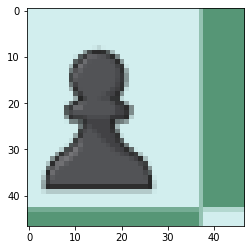

empty


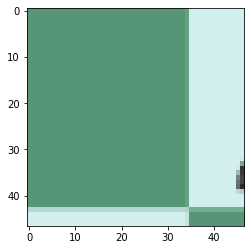

empty


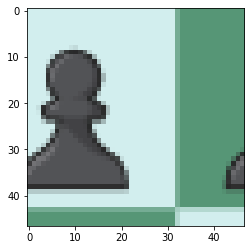

empty


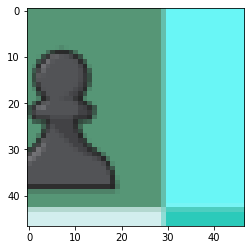

empty


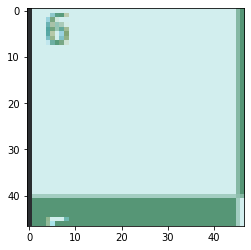

empty


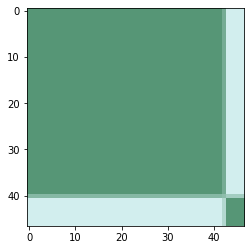

empty


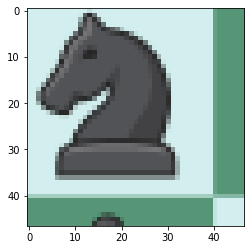

queen_black


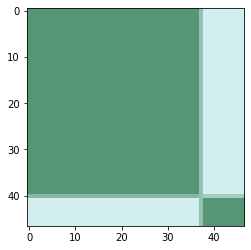

empty


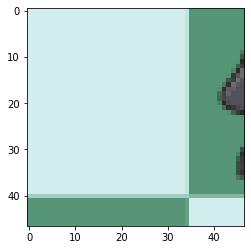

empty


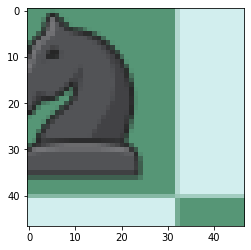

empty


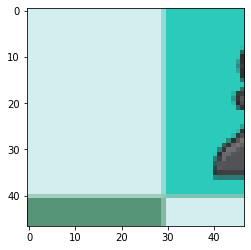

empty


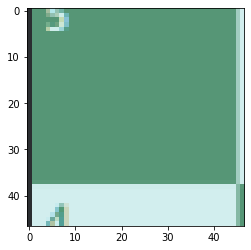

empty


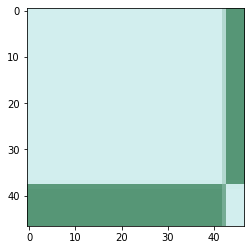

empty


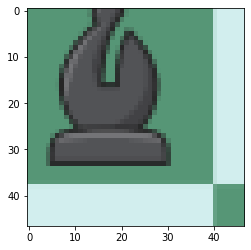

empty


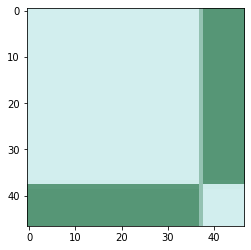

empty


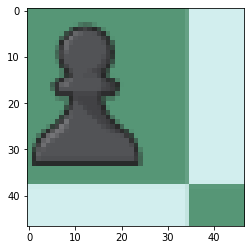

empty


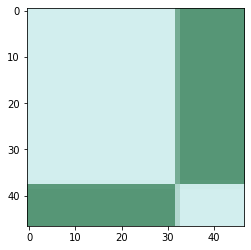

empty


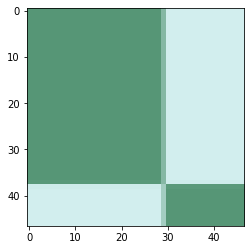

empty


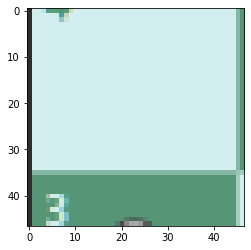

empty


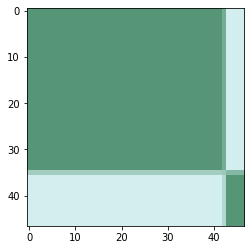

empty


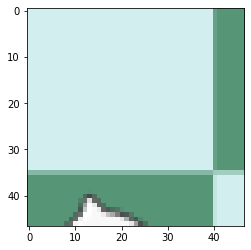

empty


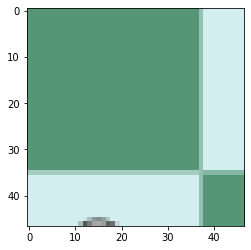

empty


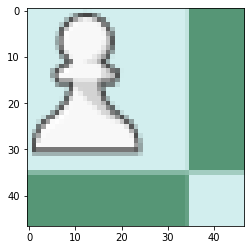

empty


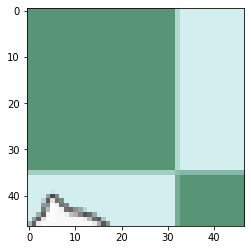

empty


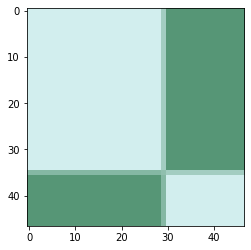

empty


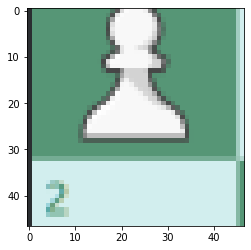

empty


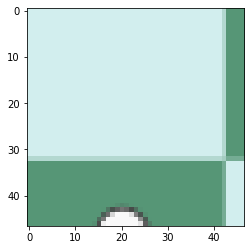

empty


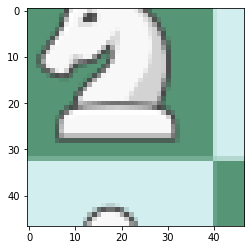

empty


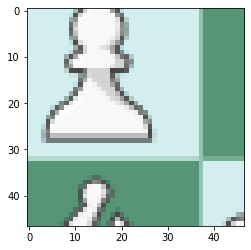

empty


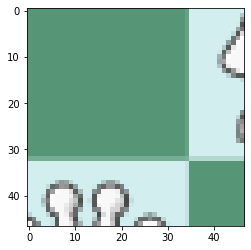

empty


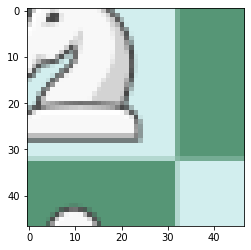

empty


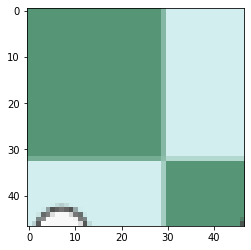

empty


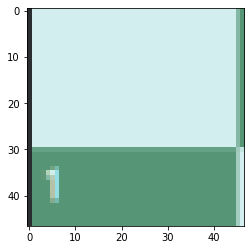

empty


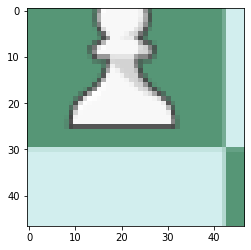

empty


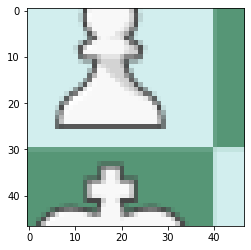

empty


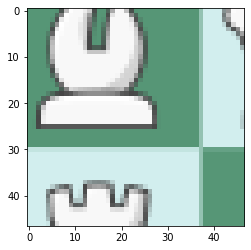

empty


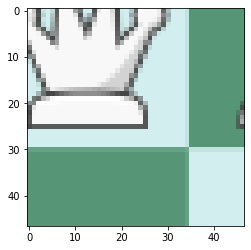

pawn_black


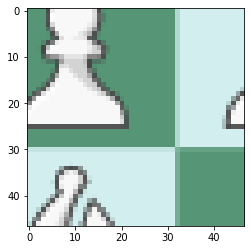

empty


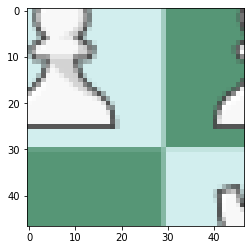

empty


In [11]:
import matplotlib.pyplot as plt

cv2.imshow("Yeet",imgs[0])
cv2.waitKey(0)
cv2.destroyAllWindows()
for i,im in enumerate(imgs):
    imgplot = plt.imshow(im)
    plt.show()
    classPredicted = dct[predictionClass[i].argmax()] # Get the class with the highest probability
    print(classPredicted)